# Overview

This notebook contains overview statistics of the `PA-2016` (Pennsylvania, year 2016) dataset and should be Part 1 of our presentation.

## Neccesary Pre-processing Goes Here

Cells are copied from the main notebook.

In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display otpions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)
np.set_printoptions(linewidth=100)

In [3]:
# TODO: merge into main notebook

# 10 primary (more important) tables
# Note that one incident is associated with up to 10 offenses
primaryTables = [
    'nibrs_arrestee', 'nibrs_bias_motivation', 'nibrs_incident',
    'nibrs_offender', 'nibrs_offense', 'nibrs_property_desc', 'nibrs_property',
    'nibrs_victim_injury', 'nibrs_victim_offender_rel', 'nibrs_victim'
]

# 24 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    'nibrs_activity_type': ('activity_type_id', 'activity_type_name'),
    'nibrs_age': ('age_id', 'age_name'),
    'nibrs_arrest_type': ('arrest_type_id', 'arrest_type_name'), 
    'nibrs_assignment_type': ('assignment_type_id', 'assignment_type_name'),
    'nibrs_bias_list': ('bias_id', 'bias_name'),
    'nibrs_circumstances': ('circumstances_id', 'circumstances_name'),
    'nibrs_cleared_except': ('cleared_except_id', 'cleared_except_name'),
    'nibrs_criminal_act_type': ('criminal_act_id', 'criminal_act_name'),
    'nibrs_drug_measure_type': ('drug_measure_type_id', 'drug_measure_name'),
    'nibrs_ethnicity': ('ethnicity_id', 'ethnicity_name'),
    'nibrs_injury': ('injury_id', 'injury_name'),
    'nibrs_justifiable_force': ('justifiable_force_id', 'justifiable_force_name'),
    'nibrs_location_type': ('location_id', 'location_name'),
    'nibrs_month': ('nibrs_month_id', 'month_num'),
    'nibrs_offense_type' : ('offense_type_id', 'offense_name'),
    'nibrs_prop_desc_type': ('prop_desc_id', 'prop_desc_name'),
    'nibrs_prop_loss_type': ('prop_loss_id', 'prop_loss_name'),
    'nibrs_relationship': ('relationship_id', 'relationship_name'),
    'nibrs_suspected_drug_type': ('suspected_drug_type_id', 'suspected_drug_name'),
    'nibrs_using_list': ('suspect_using_id', 'suspect_using_name'),
    'nibrs_victim_type': ('victim_type_id', 'victim_type_name'),
    'nibrs_weapon_type': ('weapon_id', 'weapon_name'),
    'ref_race': ('race_id', 'race_desc'),
    'ref_state': ('state_id', 'state_name')
}

# 9 secondary (less important, just for human differentiation) tables
secondaryTables = [
    'agency_participation', 'cde_agencies', 'nibrs_arrestee_weapon', 'nibrs_criminal_act',
    'nibrs_suspected_drug', 'nibrs_suspect_using', 'nibrs_victim_circumstances',
    'nibrs_victim_offense', 'nibrs_weapon'
]

In [4]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., SC-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

PA2016 = readCSVs('PA-2016')
# SC2016 = readCSVs('SC-2016')

Reading all CSVs for PA-2016 dataset...
Finished reading 43 CSVs


In [5]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 24 lookup tables


In [6]:
# TODO: merge into main notebook
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): list of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        oldCol, newCol = lookupTables[lookupTableName]
        # dic: the nested dictionary required by df.replace()
        dic = {oldCol: maps[(oldCol, newCol)]}        
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and Renaming columns...')
replaceAndRename(PA2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(PA2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(PA2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_victim'], ['nibrs_victim_type'])
replaceAndRename(PA2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(PA2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(PA2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Replacing and Renaming columns...
Done


NIBRS dataset contains mostly categorical variables, so it's best to visualize them in count plots.

For code modularization, here, we write a generic `countPlot()` function with several optional arguments used for different purposes.

In [7]:
def countPlot(df, col, hue=None, vertical=False, sort=True, topK=None, sortHues=False, topKHues=None):
    """
    Helper function for calling sns.countplot()
    Args:
        df (DataFrame): DataFrame to be plotted
        col (string): Column (categorical variable) to be counted
        hue (string): Column (categorical variable) to be grouped by
        vertical (bool): Vertical bars
        sort (bool): Whether to sort bars by decreasing counts (True) or natural order (False)
        topK (int): Keep only top K bars. None: all bars
        sortHues (bool): Sort hues by decreasing counts (True) or natural order (False)
        topKHues (int): Group by only top K hues. None: all hues
    """
    plt.figure(figsize=(8,6), dpi=100)
    if sort:
        order = df[col].value_counts().index[:topK]
    else:
        order = sorted(df[col].unique())[:topK]
        
    if sortHues:
        hueOrder = df[hue].value_counts().index[:topKHues]
    else:
        hueOrder = sorted(df[col].unique())[:topKHues]
    
    if vertical:
        sns.countplot(data=df, x=col, order=order, hue=hue, hue_order=hueOrder)
    else:
        sns.countplot(data=df, y=col, order=order, hue=hue, hue_order=hueOrder)

## Exploratory Data Analysis

### Overview Statistics

In [8]:
nIncidents = len(PA2016['nibrs_incident'])
nOffenses = len(PA2016['nibrs_offense'])
nOffenders = len(PA2016['nibrs_offender'])
nArrestees = len(PA2016['nibrs_arrestee'])
nVictims = len(PA2016['nibrs_victim'])
nIncidentsWithProp = len(PA2016['nibrs_property']['incident_id'].unique())
print('PA-2016 statistics:')
print('  %d incidents with %d offenses (%.2f per incident)'
      % (nIncidents, nOffenses, nOffenses / nIncidents))
print('  %d offenders, %d victims (both %.2f per incident), %d (%.2f%%) arrestees'
      % (nOffenders, nVictims, nOffenders / nIncidents,
         nArrestees, nArrestees / nOffenders * 100))
print('  %d (%.2f%%) incidents involve properties' %
      (nIncidentsWithProp, nIncidentsWithProp / nIncidents * 100))

PA-2016 statistics:
  5235 incidents with 6107 offenses (1.17 per incident)
  5928 offenders, 5930 victims (both 1.13 per incident), 2261 (38.14%) arrestees
  4292 (81.99%) incidents involve properties


### Merge Incident and Offense DFs

Due to the schema design of the incident and offense DataFrames, it is often more convenient to 
merge them as a single DataFrame called `incident_offense`.

In [9]:
PA2016['incident_offense'] = \
    PA2016['nibrs_incident'].merge(PA2016['nibrs_offense'], on='incident_id')
# Indeed, all offenses map to exactly one incident
print('len(PA2016[\'incident_offense\']): %d' % len(PA2016['incident_offense']))

len(PA2016['incident_offense']): 6107


In [10]:
PA2016['incident_offense'].head()

,agency_id,incident_id,month_num,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number_x,did,offense_id,offense_name,attempt_complete_flag,location_name,num_premises_entered,method_entry_code,ff_line_number_y
0,16599,83457465,1,I00000431989,NaN,2017-11-06 00:00:00,2016-01-25 00:00:00,NaN,16,4,2016-01-26 00:00:00,0,C,2016_01_PA0363100_I00000431989_INC,F,NaN,2454966,91124963,Theft From Building,C,Residence/Home,NaN,NaN,NaN
1,16599,83457473,1,I00000432105,NaN,2017-11-06 00:00:00,2016-01-28 00:00:00,NaN,20,6,NaN,0,C,2016_01_PA0363100_I00000432105_INC,F,NaN,2454965,91124972,Drug Equipment Violations,C,Highway/Road/Ally,NaN,NaN,NaN
2,16599,83886692,2,I00000433344,NaN,2017-11-06 00:00:00,2016-02-27 00:00:00,NaN,16,6,NaN,0,C,2016_02_PA0363100_I00000433344_INC,F,NaN,3484972,91618994,Simple Assault,C,Parking Lot/Garage,NaN,NaN,NaN
3,16599,84661377,4,I00000435734,NaN,2017-11-06 00:00:00,2016-04-24 00:00:00,NaN,13,6,NaN,0,C,2016_04_PA0363100_I00000435734_INC,F,NaN,5227634,92509421,Drug Equipment Violations,C,Residence/Home,NaN,NaN,NaN
4,16599,84661375,5,I00000437144,NaN,2017-11-06 00:00:00,2016-05-28 00:00:00,NaN,6,6,NaN,0,C,2016_05_PA0363100_I00000437144_INC,F,NaN,5227631,92508047,Simple Assault,C,Residence/Home,NaN,NaN,NaN


Let's look at how offenses are distributed over months by a count plot.

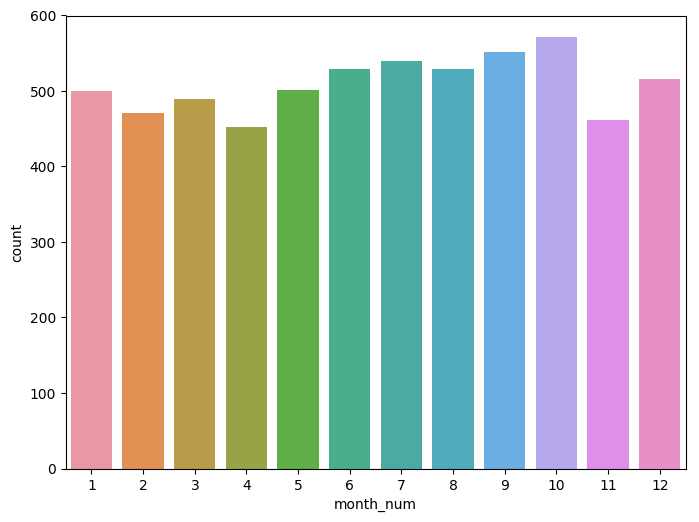

In [11]:
# Offense distribution by month
countPlot(PA2016['incident_offense'], 'month_num', vertical=True, sort=False)

The above distribution shows some slight peak months in the summer and fall (June through October).

Next, let's look at the top 20 most frequent offense types in all offenses.

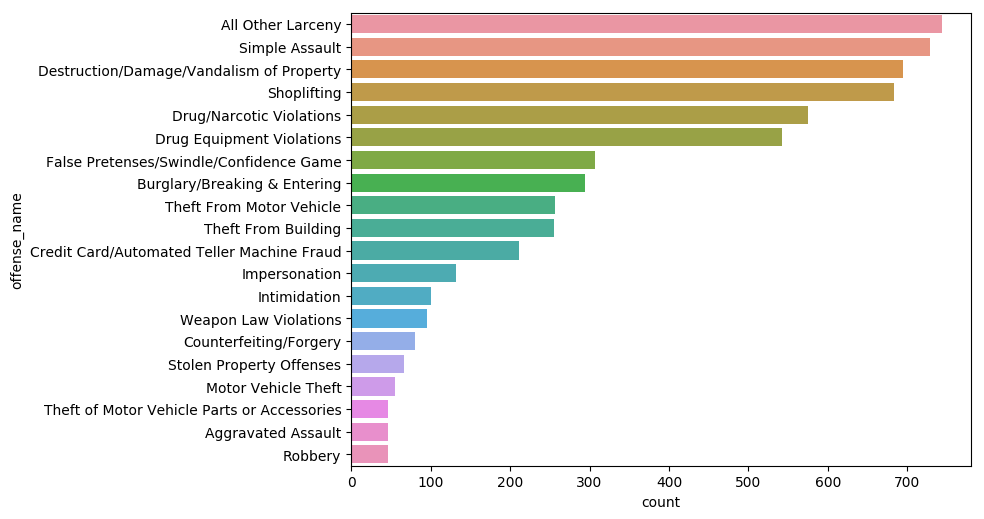

In [12]:
countPlot(PA2016['incident_offense'], 'offense_name', topK=20)

The most frequent offense types include, roughly speaking, larceny (theft such as shoplifting), simple assult, property damage, and drug violation.

We might wonder whether the monthly offense distributions agree conditioned on each offense type, so we can make a similar count plot grouped by the top 5 offense types.

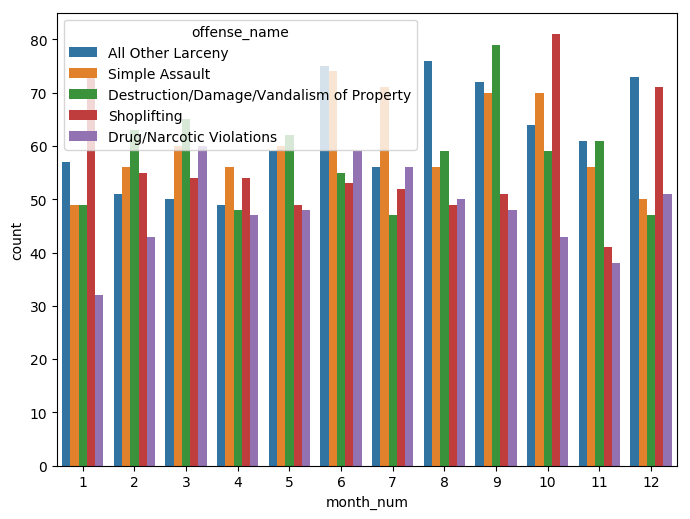

In [13]:
# Offense distribution by (offense type, month)
countPlot(PA2016['incident_offense'], 'month_num', hue='offense_name', \
          vertical=True, sort=False, sortHues=True, topKHues=5)

Interestingly, different offense types have different peak and off months. For example, Janurary is considered a off month for drug violation, but a peak month for shoplifting.